# Element volume locking

Relationships between $(\lambda,\mu)$ and $(E, \nu)$ are
\begin{equation}
\lambda=\frac{E\nu}{(1+\nu)(1-2\nu)},\,\,\,\,\mu=\frac{E}{2(1+\nu)}
\end{equation}

Basic formulation introduced above is based on stiffness, but for $\nu\rightarrow 0.5$ Young modulus $E\rightarrow\infty$ and calculations collapse with reaching $\nu=0.5$. This singularity introduces the so called volume locking. It can be seen from simple numerical experiment. Suppose rectangle domain holded on bottom and loaded on top edge and suppose almost critical value of Poisson ratio $\nu=0.4999$. The task is implemented as in *2D_Elasticity* example. The domain response should be symmetrical, but result is ...

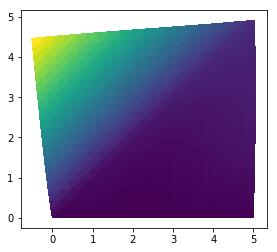

In [2]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio
lmbda, mu = E*nu/(1 + nu)/(1 - 2*nu), E/2/(1 + nu)  # Lame's constant

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
f_int = -10000000.0

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
f = fe.Constant((0.0, f_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.inner(f, u_test)*ds(1)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
plt.show()

To recover correct physical behavior, we can reformulate it to mixed variational problem. In previous example we suppose that stress tensor is defined as
\begin{equation}
\boldsymbol{\sigma}=\lambda\mathrm{div}(\mathbf{u})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}
\end{equation}
with unknown field $\mathbf{u}$. However we can define $p=-\lambda\mathrm{div}\mathbf{u}$ as hydrostatic pressure and set it as unknown field.

Previous strong form
\begin{equation}
\mathrm{div}\boldsymbol{\sigma}(\mathbf{u}) + \mathbf{f} = \mathbf{0},
\end{equation}
is replaced by two equation
\begin{equation}
\mathrm{div}\boldsymbol{\sigma}(\mathbf{u}, p) + \mathbf{f} = \mathbf{0},
\end{equation}
\begin{equation}
\mathrm{div}\mathbf{u} + \frac{p}{\lambda}=0
\end{equation}
with new definition of stress
\begin{equation}
\boldsymbol{\sigma}(\mathbf{u}, p)=p\mathbf{I} + 2\mu\boldsymbol{\varepsilon}
\end{equation}

It leads to weak form:
\begin{equation}
\int_\Omega \nabla_s \mathbf{v}:\boldsymbol{\sigma}\,\mathrm{d}\Omega - \int_\Omega q(\mathrm{div}\mathbf{u}+p/\lambda)\,\mathrm{d\Omega} = \mathcal{F}_\mathrm{ext},\,\forall \mathbf{u},\,\forall q
\end{equation}
where $\mathcal{F}_\mathrm{ext}$ is weak form of external forces. It is example of Hellinger reissner mixed formulation.

### Implementation

First of all it is necessary redefine stress function using new variable $p$.

In [13]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u, p):
    return p*fe.Identity(2) + 2*mu*epsilon(u)


Definitions of material constants remains the same. It holds also for mesh.

In [14]:
# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
f_int = -10000000.0
f = fe.Constant((0.0, f_int))

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

The crucial aspect of mixed formulation id definition of Function space. The space for displacements is vector-valued meanwhile function space for pressure variable is scalar. In addition, it is appropriate to select different degrees of space for each variable to maintain Babuška–Brezzi inf-sup condition. To implement such space in FEniCS it is necessary define individual element objects:

In [15]:
P1 = fe.VectorElement('P', fe.triangle, 2)
P2 = fe.FiniteElement('P', fe.triangle, 1)

where first stands for second-order polynomial vector-valued element and second stands for first-order polynomial scalar element. Next step is definition of mixed element by calling *MixedElement* constructor with array of individual elements.

In [16]:
element = fe.MixedElement([P1, P2])

And finally mixed function space is created by *FunctionSpace* object with mixed element as argument.

In [17]:
V = fe.FunctionSpace(mesh, element)

Dirichlet boundary condition are defined by classic way. In this case the space *V* repsesents whole mixed function space, instead of *V.sub(0)* represents vector-valued displacement subspace and *V.sub(1)* represents scalar space for pressure.

In [27]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V.sub(0), fe.Constant((0.0, 0.0)), bottom)

It is also possible to access to individual subspaces of subspace. For example following *V.sub(0).sub(1)* is space for $y$-displacements.

In [20]:
bc = fe.DirichletBC(V.sub(0).sub(1), 0.0, bottom)

Calling *fe.TestFunction(V)* in mixed formulation returns test function on whole mixed space. It is possible to extract test functions from individual spaces by function *fe.split()*, but simpler solution is calling *fe.TestFunctions(V)* instead of *fe.TestFunction(V)*. It returns splitted functions of individual spaces. The same holds for trial functions.

The weak form presented below is for nearly incompressible continuum. For full incompressibility, it is neccessary to delete $p/\lambda$ member.

In [28]:
# --------------------
# Weak form
# --------------------
u_test, p_test = fe.TestFunctions(V)
u_tr, p_tr = fe.TrialFunctions(V)

a = fe.inner(epsilon(u_test), sigma(u_tr, p_tr))*fe.dx
a += -p_test*(fe.div(u_tr) + p_tr/lmbda)*fe.dx
L = fe.inner(f, u_test)*ds(1)

Solution is obtained by classic way.

In [31]:
# --------------------
# Solver
# --------------------
sol = fe.Function(V)
fe.solve(a == L, sol, bc)

To postprocess solution, it is possible access to subspaces by *.sub(n)*.

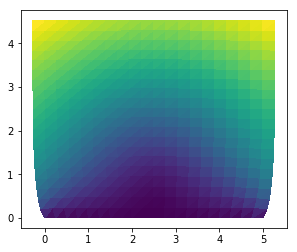

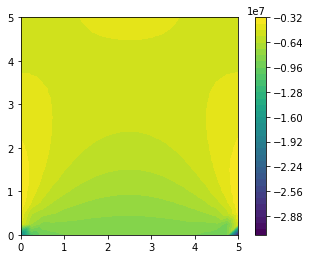

In [32]:
# --------------------
# Post-process
# --------------------
# Plot solution
fe.plot(sol.sub(0), mode="displacement")
plt.show()
plot = fe.plot(sol.sub(1))
plt.colorbar(plot)
plt.show()

### Subspace

In this example solution is saved in *sol* variable as mixed function. To acces individual subfunctions, FEniCS provides function *split*. There exists two different version of this function. The first is called via FEniCS package function as

In [38]:
u, p = fe.split(X)

It returns some kind of link on subspace. It is usually sufficient for plotting for example, but may not be sufficient for some operations with subfunctions. Therefore FEniCS provides another split function.

In [42]:
u, p = X.split()

It returns two subfunctions of type *Function*. 

### Code

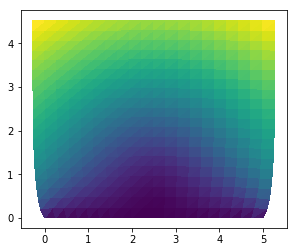

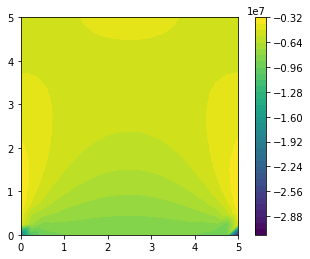

In [33]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u, p):
    return p*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
f_int = -10000000.0

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
P1 = fe.VectorElement('P', fe.triangle, 2)
P2 = fe.FiniteElement('P', fe.triangle, 1)
element = fe.MixedElement([P1, P2])
V = fe.FunctionSpace(mesh, element)
f = fe.Constant((0.0, f_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V.sub(0), fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
u_test, p_test = fe.TestFunctions(V)
u_tr, p_tr = fe.TrialFunctions(V)

a = fe.inner(epsilon(u_test), sigma(u_tr, p_tr))*fe.dx
a += -p_test*(fe.div(u_tr) + p_tr/lmbda)*fe.dx
L = fe.inner(f, u_test)*ds(1)


# --------------------
# Solver
# --------------------
sol = fe.Function(V)
fe.solve(a == L, sol, bc)

# --------------------
# Post-process
# --------------------
# Plot solution
fe.plot(sol.sub(0), mode="displacement")
plt.show()
plot = fe.plot(sol.sub(1))
plt.colorbar(plot)
plt.show()

## Mess and old code

Calling FFC just-in-time (JIT) compiler, this may take some time.


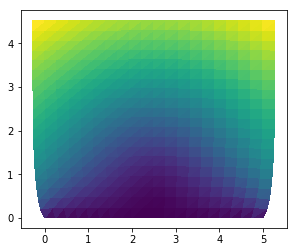

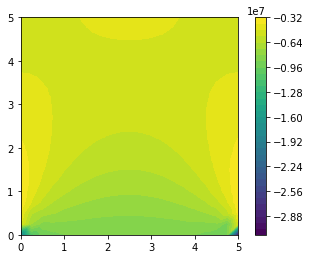

In [10]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio
G = E/2.0/(1.0 + nu)  # Shear modulus

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
f_int = -10000000.0

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
P1 = fe.VectorElement('P', fe.triangle, 2)
P2 = fe.FiniteElement('P', fe.triangle, 1)
element = fe.MixedElement([P1, P2])
V = fe.FunctionSpace(mesh, element)
f = fe.Constant((0.0, f_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V.sub(0), fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
u_test, p_test = fe.TestFunctions(V)
u_tr, p_tr = fe.TrialFunctions(V)
X = fe.Function(V)
u, p = fe.split(X)

a = 2*G*fe.inner(epsilon(u_test), epsilon(u_tr))*fe.dx
a += p_test*fe.div(u_tr)*fe.dx
a += p_tr*fe.div(u_test)*fe.dx
a -= (2*(1-2*nu))/E*p_tr*p_test*fe.dx
L = fe.inner(f, u_test)*ds(1)


# --------------------
# Solver
# --------------------
sol = fe.Function(V)
fe.solve(a == L, sol, bc)

# --------------------
# Post-process
# --------------------
# Plot solution
fe.plot(sol.sub(0), mode="displacement")
plt.show()
plot = fe.plot(sol.sub(1))
plt.colorbar(plot)
plt.show()

# # Save solution
# file = File("plane_strain/plane_strain.pvd")
# file << sol


To recover correct physical behavior, we can reformulate it to mixed variational problem. In previous example we suppose that stress tensor is defined as
\begin{equation}
\boldsymbol{\sigma}=\lambda\mathrm{div}(\mathbf{u})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}
\end{equation}
with unknown field $\mathbf{u}$. However we can define $p=-\lambda\mathrm{div}\mathbf{u}$ as hydrostatic pressure and set it as unknown field.

Previous strong form
\begin{equation}
\mathrm{div}\boldsymbol{\sigma}(\mathbf{u}) + \mathbf{f} = \mathbf{0},
\end{equation}
is replaced by two equation
\begin{equation}
\mathrm{div}\boldsymbol{\sigma}(\mathbf{u}, p) + \mathbf{f} = \mathbf{0},
\end{equation}
\begin{equation}
\mathrm{div}\mathbf{u} + \frac{p}{\lambda}=0
\end{equation}
with new definition of stress
\begin{equation}
\boldsymbol{\sigma}(\mathbf{u}, p)=p\mathbf{I} + 2\mu\boldsymbol{\varepsilon}
\end{equation}

Suppose that elastic energy density is decomposed into volumetric a deviatoric part
\begin{equation}
\frac{1}{2}\boldsymbol{\varepsilon}:\mathbf{D}:\boldsymbol{\varepsilon}=\frac{1}{2}K\varepsilon_\mathrm{V}^2 + \frac{1}{4G}\mathbf{e}:\mathbf{e}
\end{equation}
and volumetric part can be expressed as function of volumetric pressure $p$:
\begin{equation}
\frac{1}{2}\boldsymbol{\varepsilon}:\mathbf{D}:\boldsymbol{\varepsilon}=p\varepsilon_\mathrm{V} - \frac{p^2}{2K} + \frac{1}{4G}\mathbf{e}:\mathbf{e}
\end{equation}
and weak form with using $\varepsilon_\mathrm{V}=\mathrm{tr}(\boldsymbol{\varepsilon})=\mathrm{div}(\mathbf{u})$ is
\begin{equation}
\int_\Omega \frac{1}{2G}\mathbf{e}:\delta\mathbf{e}\,\mathrm{d}\Omega + 
\int_\Omega p\mathrm{div}(\delta\mathbf{u})\,\mathrm{d}\Omega + 
\int_\Omega \delta p\mathrm{div}(\mathbf{u}),\mathrm{d}\Omega - 
\int_\Omega \frac{1}{K}p\delta p\,\mathrm{d}\Omega + {\mathcal{F}}_\mathrm{ext}=0, \forall \delta\mathbf{u}, \delta p
\end{equation}
where $\mathcal{F}_\mathrm{ext}$ is weak form of external forces. It is example of Hellinger reissner mixed formulation,